# MODELS - Classification and Regression

We tested many different models. This notebook starts with a common pipeline for data formatting, then goes through the model we ended up using (LightGBM), and at the end there are several other types of models that we could also use with our data.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
set_config(display='diagram')

In [2]:
from tensorflow.keras.utils import to_categorical

data = pd.read_csv('../data/data_for_model_legs.csv')

data.head()
X = data[['trip','mean_delay','weekday','sin_time','cos_time','sin_day','cos_day','public_holiday','covid_lockdown','temp_max_combined', 'temp_min_combined','prcp_max_combined', 'snow_max_combined', 'wspd_max_combined','wpgt_max_combined', 'coco_max_combined']]
X = X[0:-1] # there is an issue with a null yas the last entry, we have to remove that one, therefore also the corresponding X
y = data['target_good_bad'] 
y = y[0:-1]
y=y.astype('int') # important as otherwise it gets attributed "object" type, which is bad for models

2022-06-15 11:38:21.427060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-15 11:38:21.427260: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

def create_preproc_ordinal():
    feat_ordinal_dict = {
        # considers "missing" as the worse category
        "coco_max_combined": [1, 2, 3, 4]
    }

    feat_ordinal = sorted(feat_ordinal_dict.keys())
    feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

    encoder_ordinal = OrdinalEncoder(
        categories=feat_ordinal_values_sorted,
        handle_unknown="use_encoded_value",
        unknown_value=-1  # Considers unknown values as worse than "missing"
    )

    preproc_ordinal = make_pipeline(
        SimpleImputer(strategy="constant", fill_value=1),
        encoder_ordinal,
        MinMaxScaler()
    )

    return preproc_ordinal, feat_ordinal


def create_preproc_numerical():
    return make_pipeline(
        KNNImputer(),
        MinMaxScaler()
    )

def create_preproc_nominal():
    return make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore")
    )

In [6]:
def create_preproc(X, percentile = 75):
    """Create an (unfitted) sklearn preprocessing pipeline well suited for the Houses Kaggle Competition

    Args:
        X (pandas.DataFrame): Feature matrix
        percentile (float): Percentage of feature to keep after one hot encoding

    Returns:
        sklearn.pipeline.Pipeline: un-fitted preprocessor
    """
    preproc_ordinal, feat_ordinal = create_preproc_ordinal()
    
    preproc_numerical = create_preproc_numerical()
    feat_numerical = sorted(X.select_dtypes(
        include=["float64"]).columns)
    
    preproc_nominal = create_preproc_nominal()
    feat_nominal = sorted(
        list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))
    
    feature_transformer = ColumnTransformer(
        [
        ("numerical_encoder", preproc_numerical, feat_numerical),
        ("ordinal_encoder", preproc_ordinal, feat_ordinal),
        ("nominal_encoder", preproc_nominal, feat_nominal)
        ],
        remainder="drop")

    feature_selector = SelectPercentile(
        mutual_info_regression,
        percentile=percentile,  # keep the xx% most important features
    )

    preproc = make_pipeline(
        feature_transformer,
        feature_selector
    )
    return preproc

In [7]:
preproc = create_preproc(X_train)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_encoder',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['coco_max_combined',
                                                   'cos_day', 'cos_time',
                                                   'mean_delay',
                                                   'prcp_max_combined',
                                                   'sin_day', 'sin_time',
                                                   'snow_max_combined',
                                                   'temp_max_combined',
                                                   'temp_min_combined',
                                                   'wpgt_max_combined',
                                                   'wspd_...
                                                                   MinMaxScaler())]),
                                                  ['coco_max_combined']),
                                                 ('nominal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['covid_lockdown',
                                                   'public_holiday', 'trip',
                                                   'weekday'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=75,
                                  score_func=<function mutual_info_regression at 0x7f88ceeeaa60>))])

In [8]:
# Fit the preprocessor on the train set
preproc.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_encoder',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['coco_max_combined',
                                                   'cos_day', 'cos_time',
                                                   'mean_delay',
                                                   'prcp_max_combined',
                                                   'sin_day', 'sin_time',
                                                   'snow_max_combined',
                                                   'temp_max_combined',
                                                   'temp_min_combined',
                                                   'wpgt_max_combined',
                                                   'wspd_...
                                                                   MinMaxScaler())]),
                                                  ['coco_max_combined']),
                                                 ('nominal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['covid_lockdown',
                                                   'public_holiday', 'trip',
                                                   'weekday'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=75,
                                  score_func=<function mutual_info_regression at 0x7f88ceeeaa60>))])

In [9]:
# Create the preprocessed versions of X_train and X_val
X_train_preproc = preproc.transform(X_train)
X_val_preproc = preproc.transform(X_val)

# Let's also already create the preprocessed version of X_test for our future predictions
X_test_preproc = preproc.transform(X_test)

In [10]:
# Shapes before preprocessing
X_train.shape, X_val.shape #X_test.shape

((150030, 16), (30006, 16))

In [11]:
# Shapes after preprocessing
X_train_preproc.shape, X_val_preproc.shape #,X_test_preproc.shape

((150030, 46), (30006, 46))

# LightGBM - Our model of choice

In [30]:
# Final model with all the best parameters - please see cells below for tests where we found out the optimal parameters

from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier

# define the model
model = LGBMClassifier(n_estimators=10000,boosting_type='dart',learning_rate=0.1,max_depth=7, num_leaves=2**7)
# fit the model on the whole dataset
model.fit(X_train_preproc, y_train)
# make a prediction
y_pred = model.predict(X_test_preproc)


In [ ]:
# Evaluate performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
y_true = y_test
accuracy = round(accuracy_score(y_true, y_pred), 2)
precision = round(precision_score(y_true, y_pred), 2)
recall = round(recall_score(y_true, y_pred), 2)
f1_score = round(f1_score(y_true, y_pred), 2)

print(accuracy)
print(precision)
print(recall)
print(f1_score)

In [ ]:
# Save the model into a .joblib that can be used for API

from sklearn.pipeline import Pipeline
import joblib

model_name = model

pipeline = Pipeline([
      ('pipeline', create_preproc(X_train)),
      ('model', model_name)
    ])
pipeline.fit(X_train, y_train)

joblib.dump(pipeline, 'model.joblib')

## Exploration of other parameters

Lots of repeated functions and imports here. The idea was that you could run each cell autonomously, as the models were tested in several computers in parallel, and it's hard to keep track of where you are inside the notebook.

>10 0.662 (0.001)
>50 0.672 (0.002)
>100 0.674 (0.002)
>500 0.676 (0.002)
>1000 0.675 (0.002)
>5000 0.671 (0.002)
>10000 0.669 (0.002)


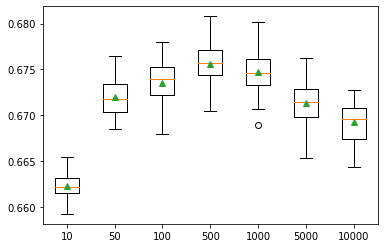

In [15]:
# number of trees
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
	models = dict()
	trees = [10, 50, 100, 500, 1000, 5000,10000]
	for n in trees:
		models[str(n)] = LGBMClassifier(n_estimators=n)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X_train_preproc, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>1 0.618 (0.018)
>2 0.629 (0.018)
>3 0.639 (0.016)
>4 0.643 (0.016)
>5 0.648 (0.017)
>6 0.647 (0.015)
>7 0.649 (0.011)
>8 0.648 (0.017)
>9 0.648 (0.018)
>10 0.644 (0.017)


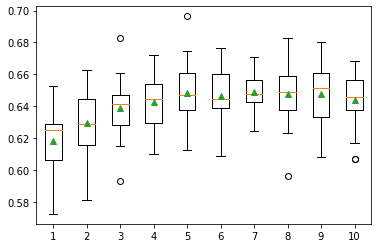

In [14]:
# tree depth
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,11):
		models[str(i)] = LGBMClassifier(max_depth=i, num_leaves=2**i)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X_train_preproc, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>0.0001 0.594 (0.001)
>0.0010 0.594 (0.001)
>0.0100 0.637 (0.014)
>0.1000 0.648 (0.018)
>1.0000 0.618 (0.018)


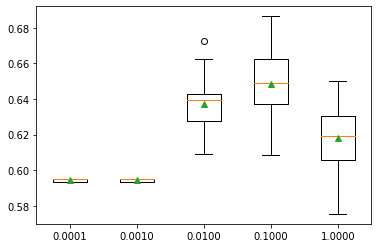

In [16]:
# explore learning rate
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from matplotlib import pyplot
  
# get a list of models to evaluate
def get_models():
	models = dict()
	rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
	for r in rates:
		key = '%.4f' % r
		models[key] = LGBMClassifier(learning_rate=r)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X_train_preproc, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>gbdt 0.648 (0.018)
>dart 0.650 (0.015)
>goss 0.632 (0.016)


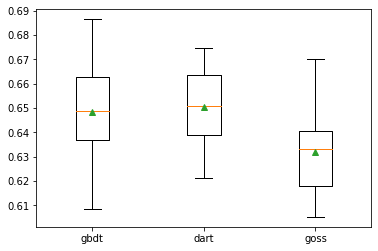

In [17]:
# boosting type
from numpy import arange
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
	models = dict()
	types = ['gbdt', 'dart', 'goss']
	for t in types:
		models[t] = LGBMClassifier(boosting_type=t)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X_train_preproc, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>1000_0.05_6_dart 0.647 (0.015)
>1000_0.05_6_goss 0.634 (0.023)
>1000_0.1_6_dart 0.647 (0.017)
>1000_0.1_6_goss 0.629 (0.022)
>1000_0.2_6_dart 0.640 (0.021)
>1000_0.2_6_goss 0.623 (0.019)
>1000_0.5_6_dart 0.632 (0.023)
>1000_0.5_6_goss 0.548 (0.028)


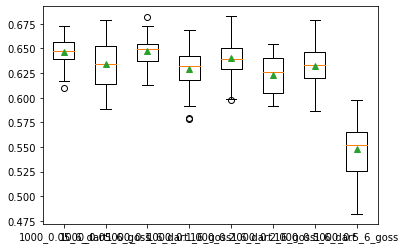

In [59]:
# combine a bunch of these params into one bigger grid search to check whether their interaction affects anything 
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
	models = dict()
	trees = [1000]
	types = ['dart', 'goss']
	rates = [0.05, 0.1,0.2,0.5]
	for i in range(6,7):
		for r in rates:
				for t in types:
						for n in trees:
							key = str(n)+'_'+str(r)+'_'+str(i)+'_'+t
							models[key] = LGBMClassifier(n_estimators=n,boosting_type=t,learning_rate=r,max_depth=i, num_leaves=2**i)
			

	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X_train_preproc, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Other models - Classification

## Logistic regression

### Grid Search to find parameters such as target balancing

In [77]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, cross_validate

# define weight hyperparameter - important for target balancing
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]

hyperparam_grid = {"class_weight": w }

log_reg = LogisticRegression(max_iter=10000) 

grid = GridSearchCV(log_reg,hyperparam_grid,scoring="accuracy", cv=5, n_jobs=-1, refit=True)
grid.fit(X_train_preproc,y_train)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')




Best score: 0.6660801173098714 with param: {'class_weight': {0: 1.0, 1: 1.0}}


### Regular logistic regression with cross validation

In [76]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression

# define model
lg3 = LogisticRegression(random_state=1, class_weight={0: 1, 1: 1},max_iter=10000) # use best hyperparams from grid search here
# fit it
lg3.fit(X_train_preproc,y_train)
# test
y_pred = lg3.predict(X_test_preproc)
# performance
#print(f'Confusion Matrix: {confusion_matrix(y_test, y_pred,normalize='all')}')
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')
print(f'Precision score: {precision_score(y_test,y_pred)}')

Accuracy Score: 0.6616845788552862
Area Under Curve: 0.5487250422382742
Recall score: 0.9246617466174661
Precision score: 0.6751234845083072


In [ ]:

cv_results = cross_validate(log_reg, X_train_preproc, y_train, cv=5, 
                            scoring=['max_error',
                                     'r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error']
                           )

log_reg.fit(X_test_preproc,y_test)
cv_results = pd.DataFrame(cv_results)
r2 = cv_results['test_r2'].mean()
max_error = cv_results['test_max_error'].max()

In [ ]:
r2

-0.5406702234981353

# KNN Classifier

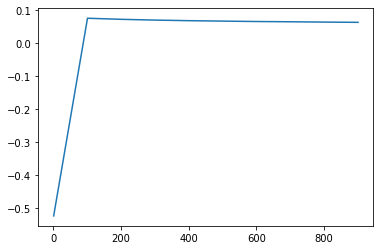

In [21]:
# Run a search with cross_validate to find the optimal
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate

k_range = range(1,1000,100) # Totally arbitrary, but previous testing suggests it's best to use at least 180

scores = []

# We append the scores in the dictionary
for k in k_range:
    neigh = KNeighborsRegressor(n_neighbors=k)
    cv_results = cross_validate(neigh, X_train_preproc, y_train, cv=3, 
                            scoring=['max_error',
                                     'r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error']
                           )
    cv_results = pd.DataFrame(cv_results)
    scores.append(cv_results['test_r2'].mean())
       
plt.plot(k_range, scores, label = 'Training score')
#plt.plot(scores_, test_scores_mean, label = 'Test score')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


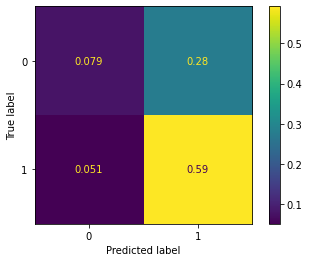

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_predict

neigh = KNeighborsClassifier(n_neighbors=200)
neigh.fit(X_train_preproc,y_train)
#y_pred = cross_val_predict(model,X_val_preproc,y_val,cv=5,method='predict').T
y_pred = neigh.predict(X_test_preproc)

plot_confusion_matrix(neigh,X_test_preproc,y_test) 
plt.show()


In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

y_true = y_test
accuracy = round(accuracy_score(y_true, y_pred), 2)
precision = round(precision_score(y_true, y_pred), 2)
recall = round(recall_score(y_true, y_pred), 2)
f1_score = round(f1_score(y_true, y_pred), 2)

print(accuracy)
print(precision)
print(recall)
print(f1_score)
print(classification_report(y_test, y_pred))

0.67
0.68
0.92
0.78
              precision    recall  f1-score   support

           0       0.61      0.22      0.33      6302
           1       0.68      0.92      0.78     11358

    accuracy                           0.67     17660
   macro avg       0.65      0.57      0.55     17660
weighted avg       0.66      0.67      0.62     17660



In [ ]:
leaf_size = list(range(1,50,10))
n_neighbors = [200]
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

## Neural Network Classifier

In [ ]:
from tensorflow.keras import Sequential, layers

def initialize_model(X):

    model = Sequential()
    
    # Input Layer
    model.add(layers.Dense(64, activation='relu', input_dim = X.shape[-1]))
    
    # Hidden Layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3)
    
    # Predictive Layer
    model.add(layers.Dense(1, activation='softmax')) 
    
    # Compiler     
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])  
    
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
tf.config.run_functions_eagerly(True)

es = EarlyStopping(patience=3, restore_best_weights=True)

# 1. Initializing a NeuralNet with its architecture and its compilation method
model = initialize_model(X_train_preproc)
model.summary()

# 2. Training the model
epochs = 50
batch_size = 64

history = model.fit(X_train_preproc, 
                    y_train,
                    validation_data = (X_val_preproc, y_val),
                    epochs = epochs,        
                    batch_size = batch_size, 
                    callbacks=[es],
                    verbose = 1)

# 3. Evaluating the model
res = model.evaluate(X_val_preproc, y_val, verbose = 0)
print(f"RMLSE achieved after {epochs} epochs = {round(res**0.5,3)}")

# 4. Looking at the lowest loss
minimium_rmlse_val = min(history.history['val_loss'])**0.5
optimal_momentum = np.argmin(history.history['val_loss'])

print(f"Lowest RMLSE achieved = {round(minimium_rmlse_val,3)}")
print(f"This was achieved at the epoch number {optimal_momentum}") 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                3200      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 64)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


2935/2935 [==============================] - 74s 25ms/step - loss: 0.6249 - accuracy: 0.6325 - val_loss: 0.6197 - val_accuracy: 0.6212
Epoch 2/50
2935/2935 [==============================] - 81s 28ms/step - loss: 0.6149 - accuracy: 0.6325 - val_loss: 0.6176 - val_accuracy: 0.6212
Epoch 3/50
2935/2935 [==============================] - 73s 25ms/step - loss: 0.6100 - accuracy: 0.6325 - val_loss: 0.6151 - val_accuracy: 0.6212
Epoch 4/50
2935/2935 [==============================] - 68s 23ms/step - loss: 0.6058 - accuracy: 0.6325 - val_loss: 0.6087 - val_accuracy: 0.6212
Epoch 5/50
2935/2935 [==============================] - 68s 23ms/step - loss: 0.6029 - accuracy: 0.6325 - val_loss: 0.6106 - val_accuracy: 0.6212
Epoch 6/50
2935/2935 [==============================] - 72s 25ms/step - loss: 0.5999 - accuracy: 0.6325 - val_loss: 0.6064 - val_accuracy: 0.6212
Epoch 7/50
2935/2935 [==============================] - 72s 25ms/step - loss: 0.5979 - accuracy: 0.6325 - val_loss: 0.6032 - val_accura

KeyboardInterrupt: ignored

In [ ]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
    
plot_history(history)

## Keras Classifier

In [ ]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(40, input_dim=40, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=2, shuffle=True)
results = cross_val_score(estimator, X_train_preproc, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# larger model
def create_larger():
	# create model
	model = Sequential()
	model.add(Dense(62, input_dim=62, activation='relu'))
	model.add(Dense(30, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
kclass = KerasClassifier(build_fn=create_larger, epochs=100, batch_size=5, verbose=0)))

kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(kclass, X_train_preproc, y_train, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# Other models - Regression

## KNN Regressor

In [ ]:
# Run a search with cross_validate to find the optimal
from sklearn.neighbors import KNeighborsRegressor

k_range = [180, 190, 200, 210, 220, 230, 240, 250] # Totally arbitrary, but previous testing suggests it's best to use at least 180

scores = []

# We append the scores in the dictionary
for k in k_range:
    neigh = KNeighborsRegressor(n_neighbors=k)
    cv_results = cross_validate(neigh, X_train_preproc, y_train, cv=5, 
                            scoring=['max_error',
                                     'r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error']
                           )
    cv_results = pd.DataFrame(cv_results)
    scores.append(cv_results['test_r2'].mean())
       
plt.plot(k_range, scores, label = 'Training score')

In [ ]:
# Use the optimal K and cross  validate more times to find a stable test result
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=200)

cv_results = cross_validate(neigh, X_train_preproc, y_train, cv=15, 
                            scoring=['max_error',
                                     'r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error']
                           )
cv_results = pd.DataFrame(cv_results)
score = cv_results['test_r2'].mean()
score

In [ ]:
cv_results

## XGBoost Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

xgb = GradientBoostingRegressor(max_depth=10, n_estimators=100, learning_rate=0.1)
#xgb = XGBRegressor(max_depth=5, n_estimators=60, learning_rate=0.5) ### standard from lecture
#xgb = XGBRegressor(learning_rate=0.05, max_depth = 1, n_estimators = 50) 
#(max_depth=10, n_estimators=100, learning_rate=0.1) 

cv_results = cross_validate(xgb, X_train_preproc, y_train, cv=15, 
                            scoring=['max_error',
                                     'r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error'])

#xgb.fit(transformed,y)
cv_results = pd.DataFrame(cv_results)
score = cv_results['test_r2'].mean()
score

## Neural Network Regressor

In [ ]:
from tensorflow.keras import Sequential, layers
from keras.layers import Dropout
from tensorflow import keras

def initialize_model(X):

     model = Sequential()
    
    # Input Layer
    model.add(layers.Dense(50, activation='relu', input_dim = X.shape[-1]))
    
    # Hidden Layers
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(Dropout(0.1))
    model.add(layers.Dense(15, activation='relu'))
    model.add(Dropout(0.15))   
    model.add(layers.Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    
    # Predictive Layer
    model.add(layers.Dense(1, activation='linear'))
    
    opt = keras.optimizers.Adam()

    model.compile(optimizer=opt,
                  #loss='msle')      # directly optimize for the squared log error!
                  loss='mean_squared_error')
    
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
tf.config.run_functions_eagerly(True)

es = EarlyStopping(patience=5, restore_best_weights=True)

model = initialize_model(X_train_preproc)
model.summary()

# Training the model
epochs = 150
batch_size = 32

history = model.fit(X_train_preproc, 
                    y_train,
                    validation_data = (X_val_preproc, y_val),
                    epochs = epochs,         
                    batch_size = batch_size, 
                    callbacks=[es],
                    verbose = 1)

# 3. Evaluating the model
res = model.evaluate(X_val_preproc, y_val, verbose = 0)
print(f"RMLSE achieved after {epochs} epochs = {round(res**0.5,3)}")

# 4. Looking at the lowest loss
minimium_rmlse_val = min(history.history['val_loss'])**0.5
optimal_momentum = np.argmin(history.history['val_loss'])

print(f"Lowest RMLSE achieved = {round(minimium_rmlse_val,3)}")
print(f"This was achieved at the epoch number {optimal_momentum}") 

In [ ]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
  
plot_history(history)